# Tutorial7: 使用自定义镜像和模型

SCOW-for-AI 还可以上传自定义的镜像、模型、数据、文件等，通过 GUI 中的 “训练” 模块，可以快速地使用自定义镜像进行模型训练。我们把 Tutorial5 的训练环境打包并上传至云，通过拉取远程镜像来获取镜像文件，进而创建 SCOW-for-AI 上的镜像。

分以下几步来实现：
1. 拉取镜像并创建镜像
2. 上传数据、模型、算法脚本
3. 创建数据、模型、算法
4. 创建训练任务
5. 查看结果

## 1. 拉取镜像并创建镜像

Docker是一种开源的容器化平台，旨在通过将应用程序及其依赖项打包到轻量级、可移植的容器中，简化软件的开发、部署和运行。它允许开发者在任何环境中一致地运行应用程序，从而提高开发效率和运维灵活性。SCOW-for-AI 是支持用户使用自定义的镜像，由于镜像文件一般较大，本地上传速度很慢，我们建议用户将自己的镜像上传至云服务商，然后通过拉取远程镜像在 SCOW-for-AI 平台上使用。

进入到镜像功能选项卡：

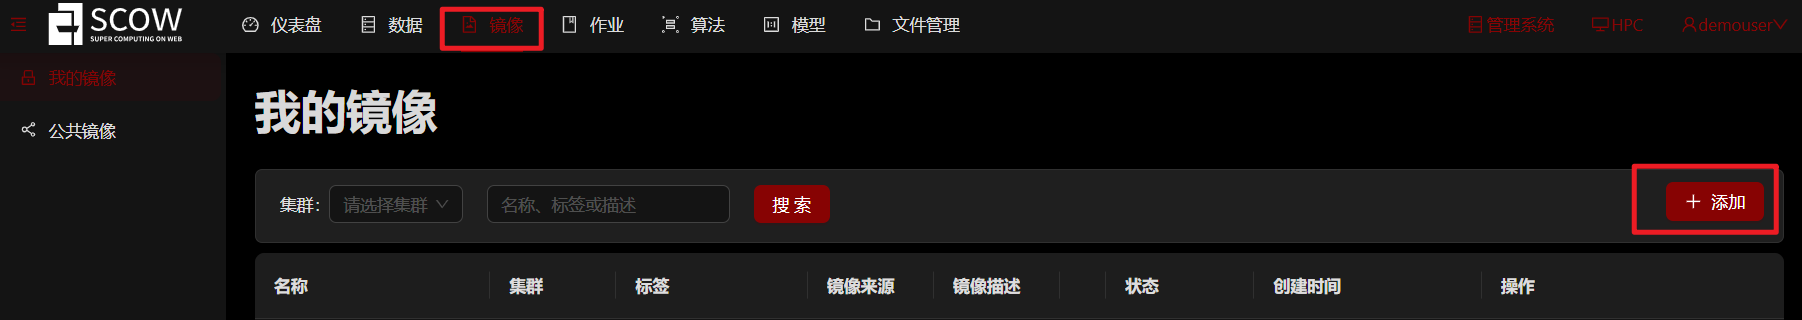

填写镜像地址和参数，点击创建：

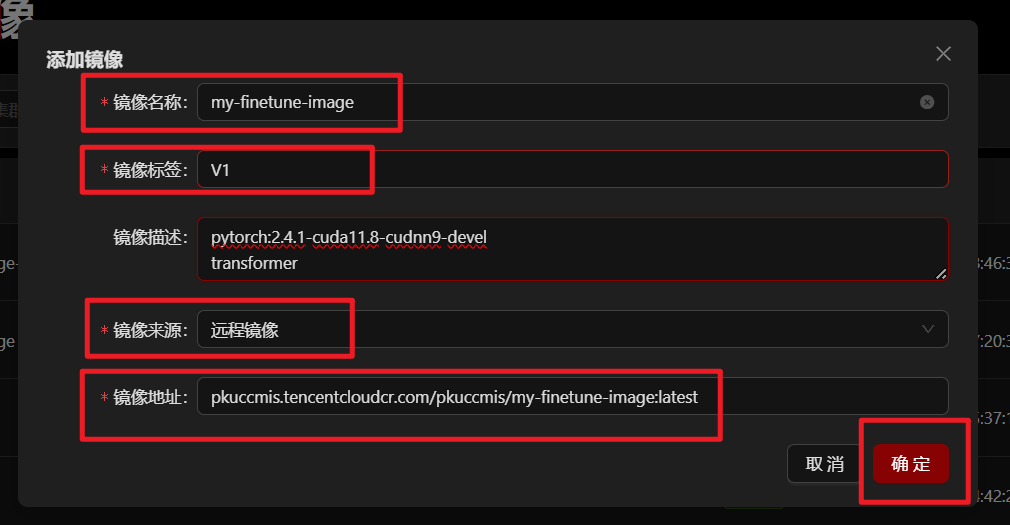

创建后的镜像可以在 “我的镜像” 中查看，也可以将镜像分享为公共镜像：

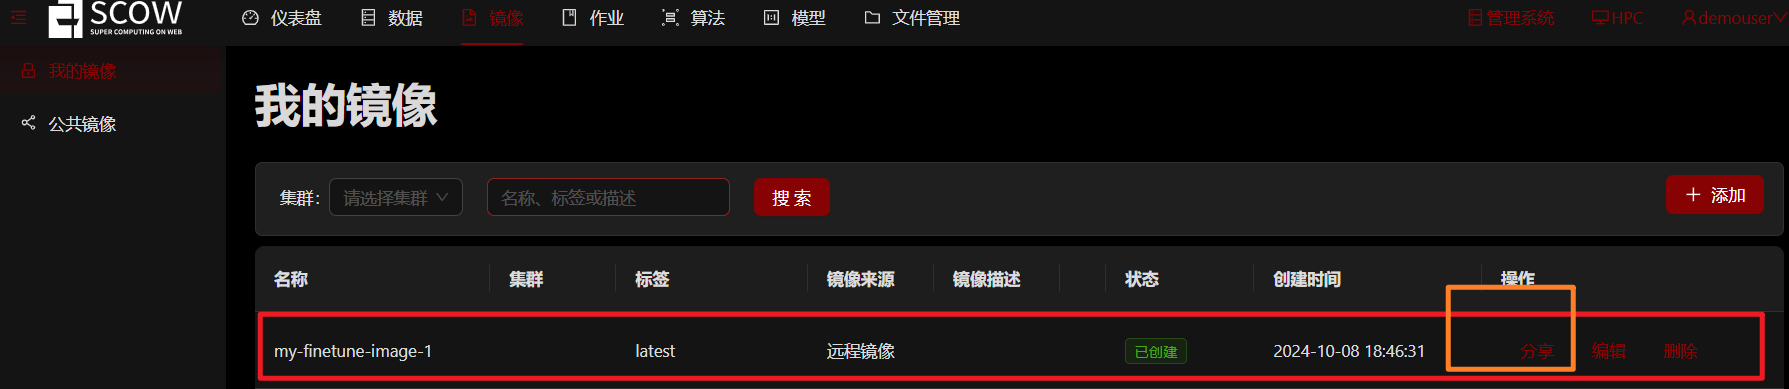

## 2. 上传数据、模型、算法脚本

本章使用的数据、模型、算法文件在 Tutorial5 中。

通过 “文件管理” 将数据、模型、算法脚本上传到 SCOW-for-AI 平台：

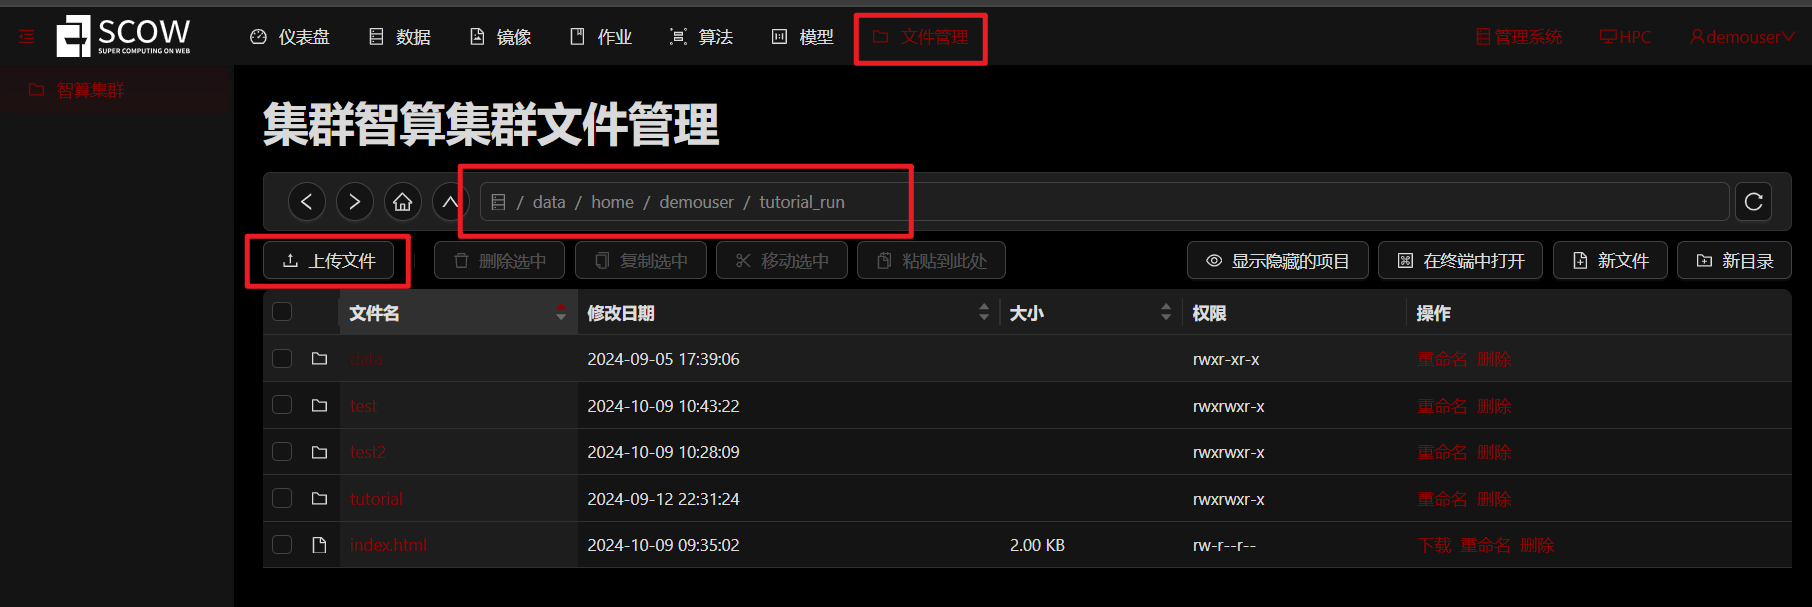

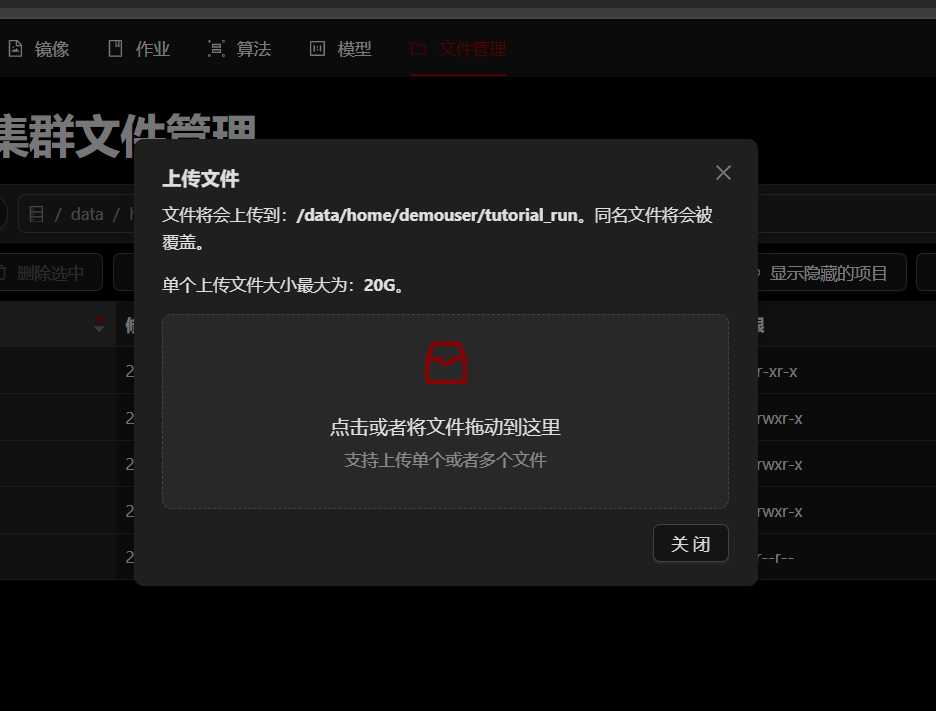

我们上传的是 bert-base-uncased 模型和 MRPC（Microsoft Research Paraphrase Corpus）数据集。脚本内容如下：

下面部分不在 jupyter notebook 中运行。

需根据模型上传路径修改下面文件的 model_path 和 data_path 变量后，将文件复制为 train.py 并上传到集群。

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler, DataCollatorWithPadding
import torch
from tqdm.auto import tqdm
import os
import evaluate
import numpy as np

# 模型和数据路径
model_path = "model"
data_path = "data"

# 加载模型
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

# 加载数据
raw_datasets = load_dataset(data_path)

# 分词，使用 .map 方法为数据集添加 token 相关的 key
tokenizer = AutoTokenizer.from_pretrained(model_path)
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# 数据处理，去除不相关的 key，重命名 label key
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# 指定 batch_size
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 按照 batch 中最大的长度自动填充 padding
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

# 硬件
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# 训练参数
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# 评估函数
metric = evaluate.load("glue", "mrpc")
def compute_eval(model, eval_dataloader, device, metric=metric):
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])
    
    eval_result = metric.compute()
    
    return eval_result

# 训练过程
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
    
        # 前向传播
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 更新参数
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
        
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    print(f"Epoch {epoch}: eval metric --> {compute_eval(model, eval_dataloader, device)}")

## 3. 创建数据、模型、算法

### 3.1 创建数据：

进入数据创建页面：

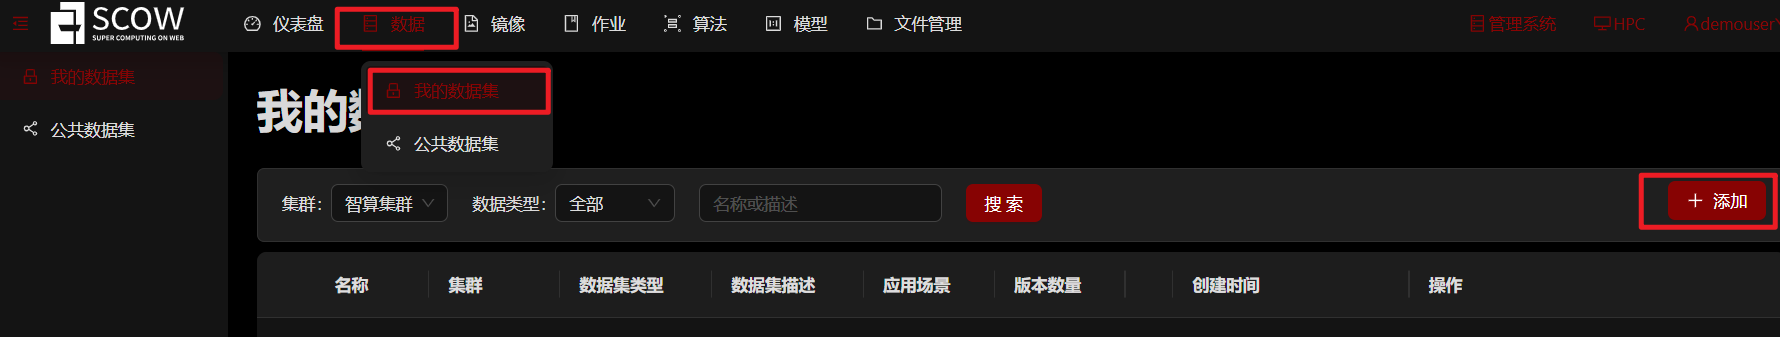

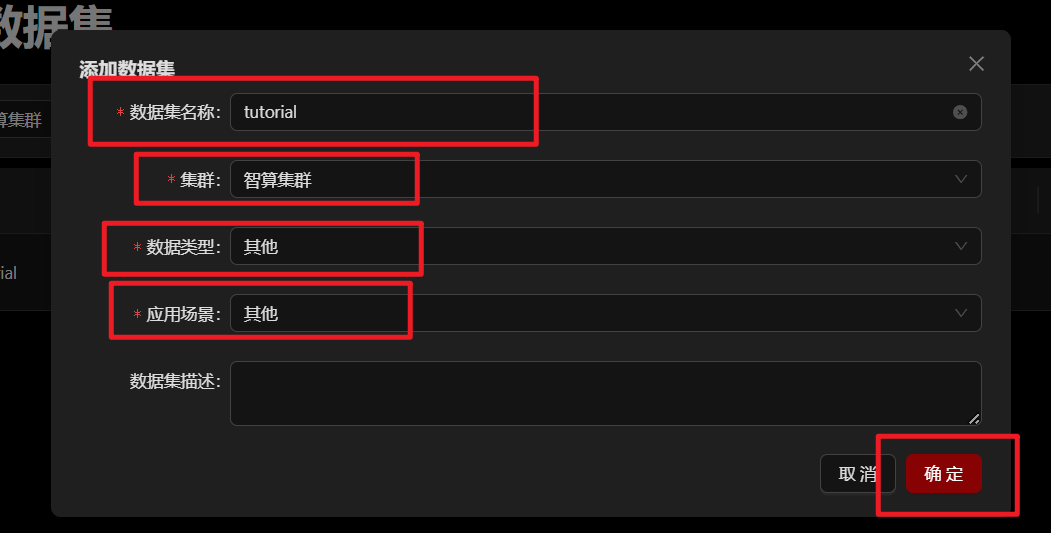

然后点击“创建新版本”

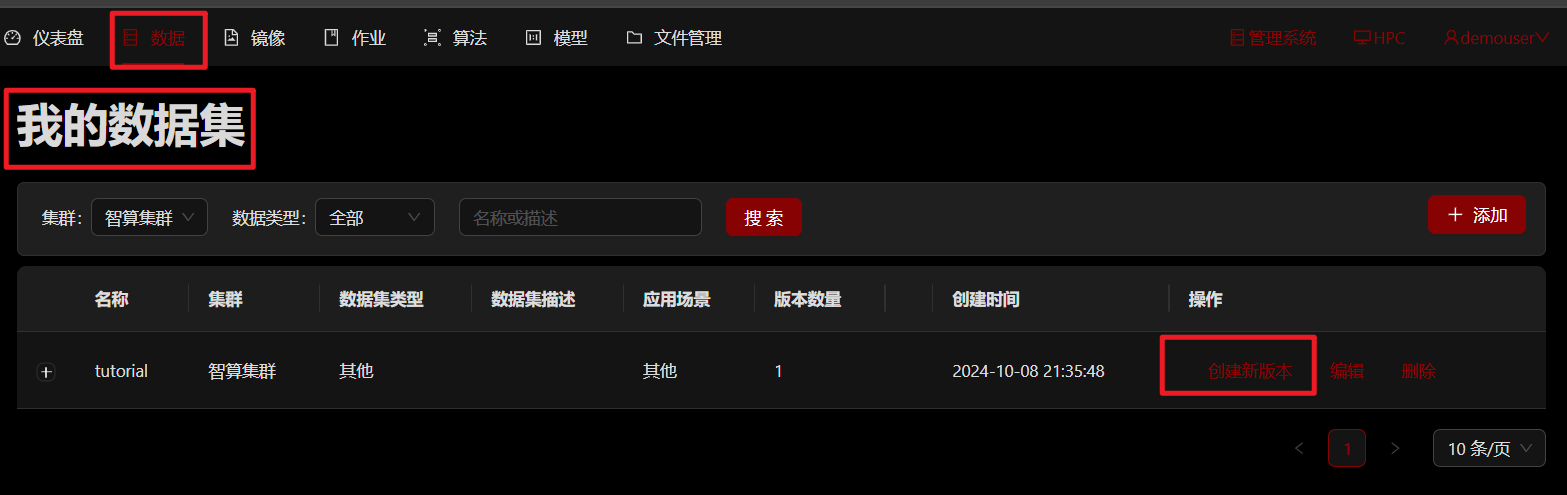

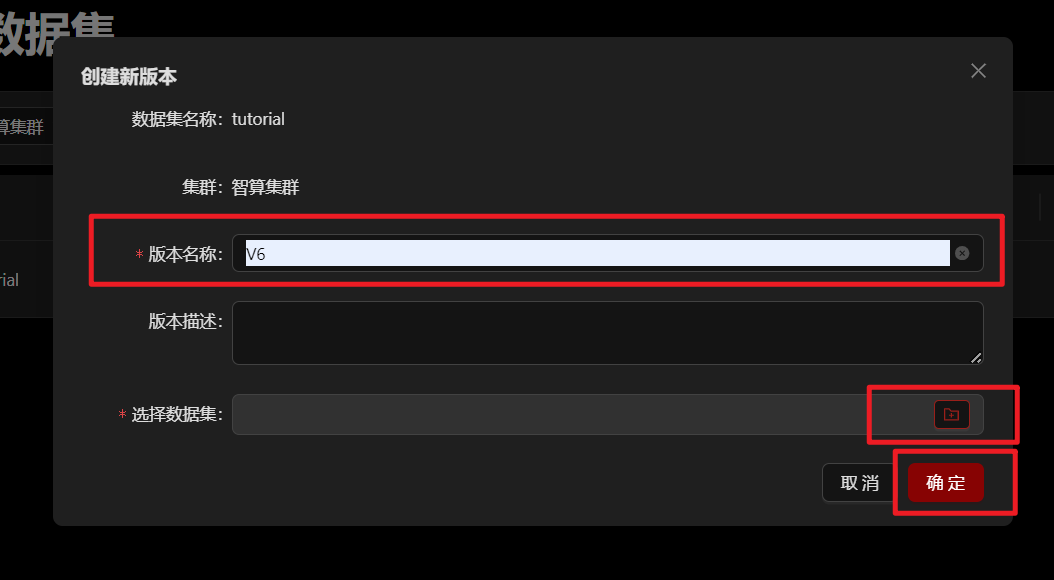

选择数据文件所在的路径：

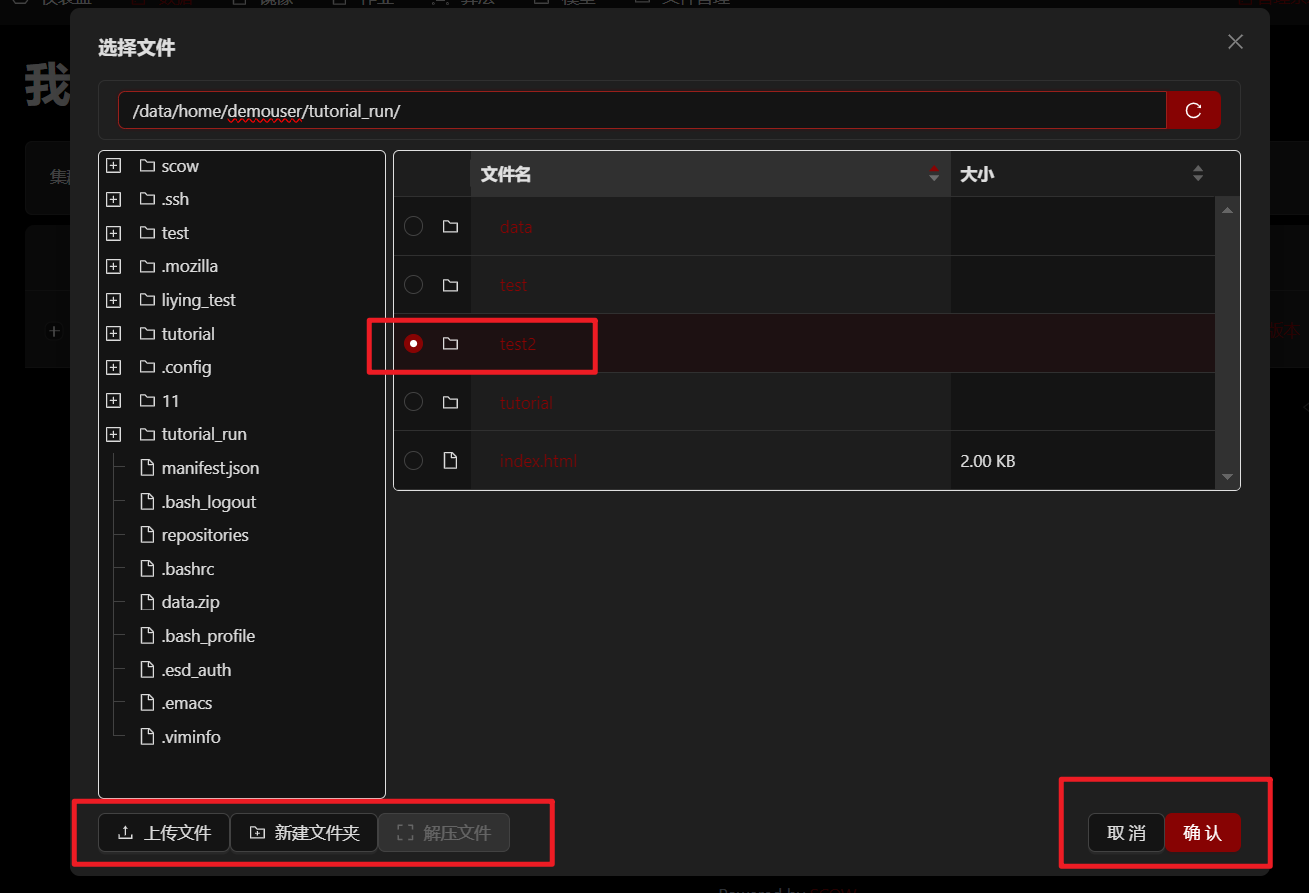

（也可以跳过第二节，在这里直接上传并解压文件）

### 3.2 创建模型：

进入模型创建页面：

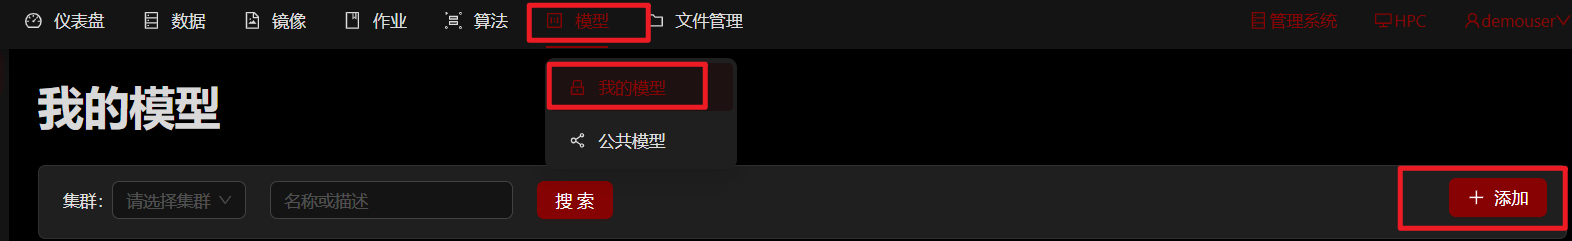

后面操作和创建数据一样。

### 3.3 创建算法

进入算法创建页面：

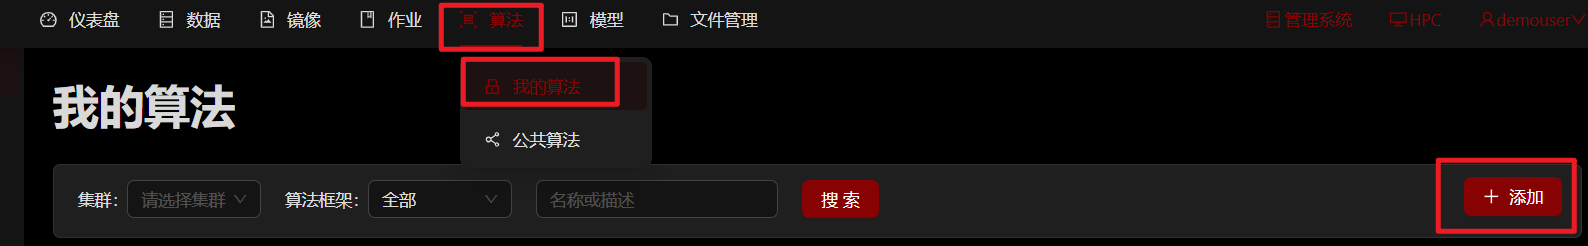

后面操作和创建数据一样。

## 4. 创建训练任务

进入训练任务创建页面：

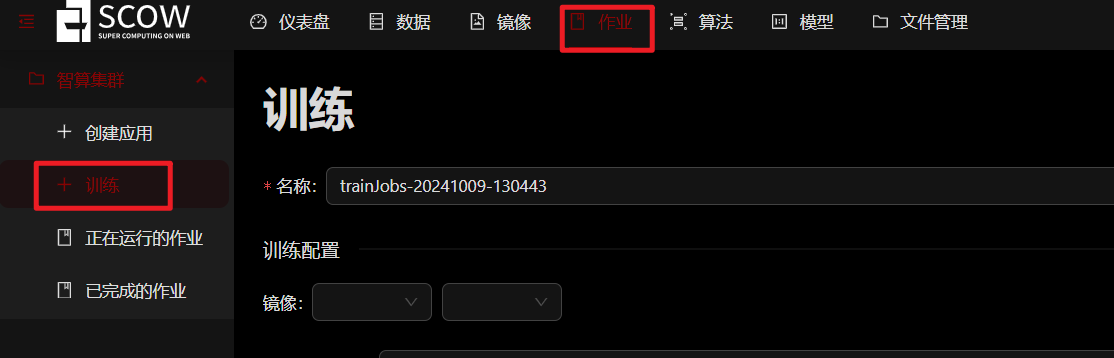

根据用户设置填写训练任务信息：

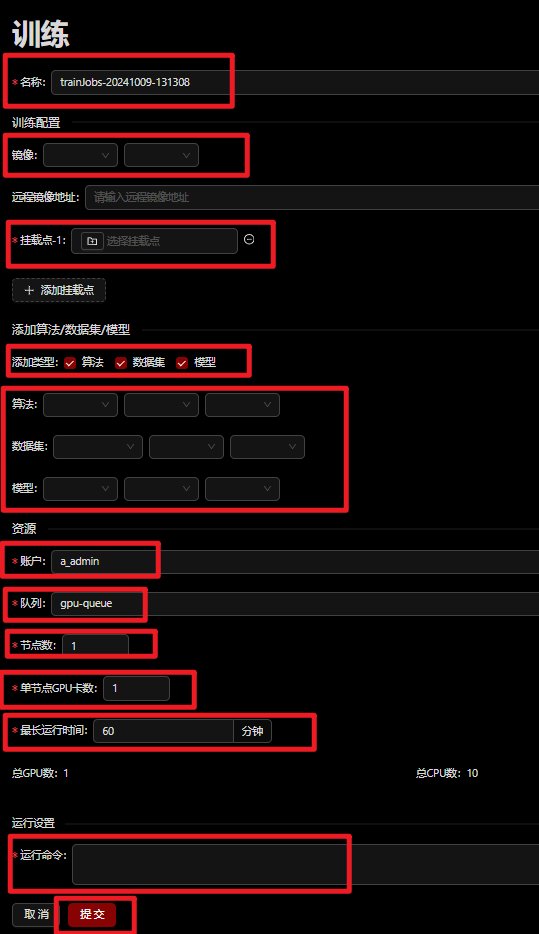

提交任务。

在“运行命令”窗口中，可以运行多条命令，命令之间用英文分号隔开。用户需根据自己的路径修改下面命令。（路径我们用 {} 标出）

根据用户自己设置的路径修改下面命令，

我们填写的是：

```bash
cd {/data/home/demouser/tutorial_run}; /bin/bash; source activate finetine; export HF_ENDPOINT=https://hf-mirror.com; python -c "import evaluate; metric = evaluate.load('glue', 'mrpc'); print(metric)"; python train.py > log
```

运行过程中，可以查看作业运行情况：

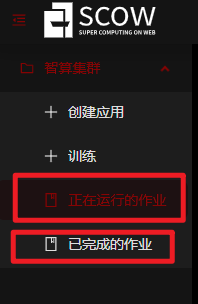

运行结束后在“文件管理”页面中查看输出文件：

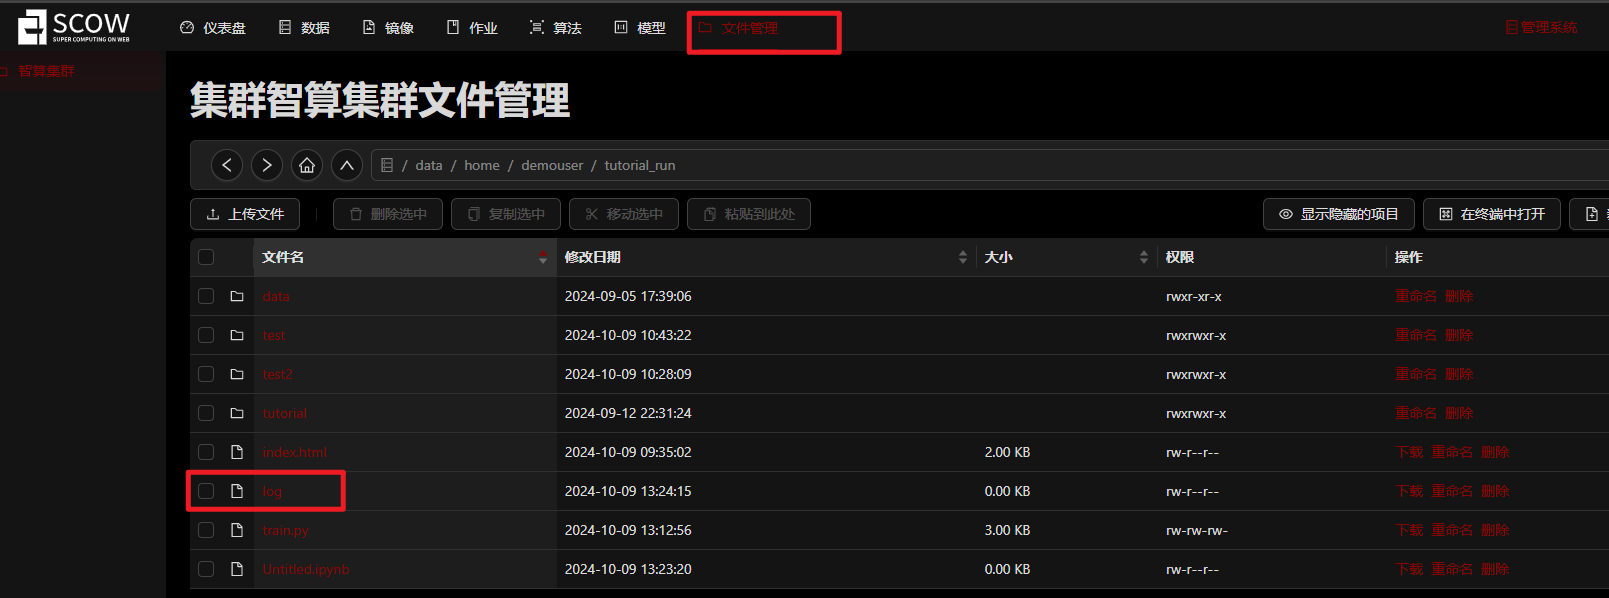